# Alert Prediction in OpenShift Container Platform deployments

**Author(s):** Surya Prakash Pathak (supathak@redhat.com)

**Date Created:** 07-28-2020

**Date Updated:** 08-12-2020

**Tags:** #data-science #ocp #ccx #aiops #alert-prediciton #time-series-forecasting #random-forest #support-vector-machine #confusion-matrix #accuracy #recall #prediction

# Abstract

If a customer’s OpenShift deployment goes down, it can have a significant impact on their business. Since there are variety of reasons why an OpenShift cluster might fail, finding and fixing the issue that the cluster suffers from is not always trivial. However, if we can predict in advance whether a cluster will run into a given issue, then we may be able to fix it before it fails or before it severely impacts the customer. Issues in a cluster are often defined by, or closely related to, the alerts that it fires. So predicting alerts can be a step towards predicting the underlying issue.

Thus, the goal of this project is to explore the use of machine learning classification algorithm like random forest and support vector, to predict whether a deployment will fire a given alert within the next hour.

# Introduction

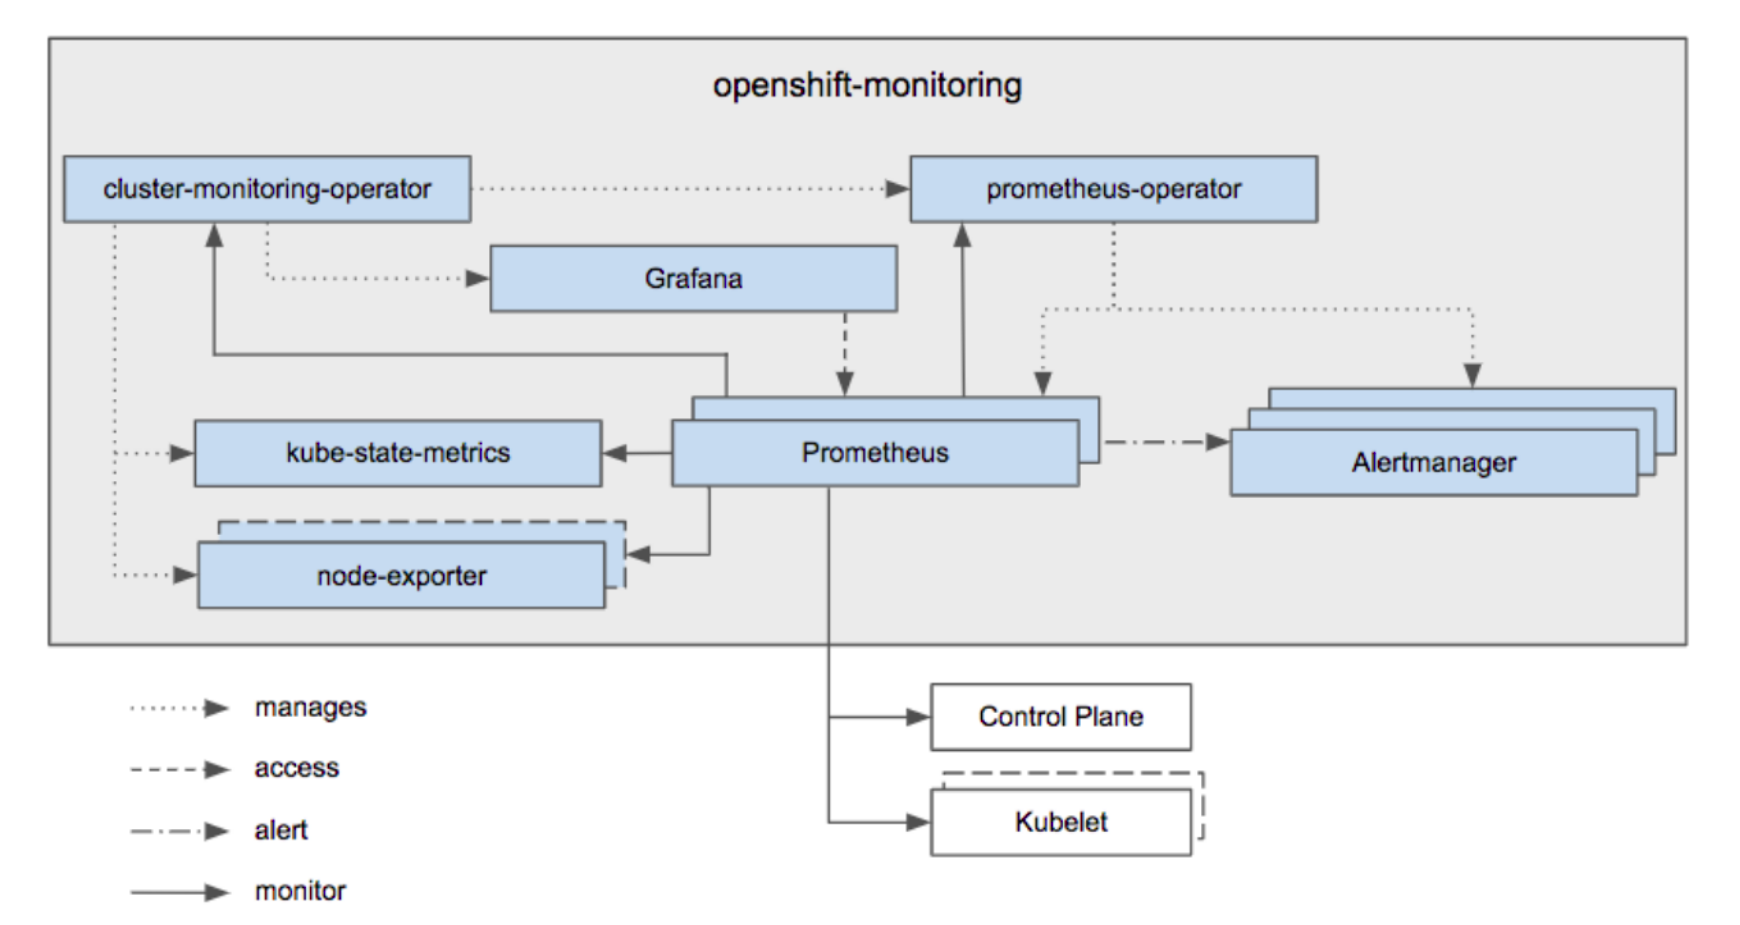

In [45]:
from IPython.display import Image
Image('ocp.png')

The openshift container platform consists of preconfigured, self-isolating, monitoring stack that is based on a Prometheus open source project. 

In the above figure, we can see cluster monitoring operator, which watches over the deployed monitoring components and resources, and ensures that they are always up to date. The Prometheus operator creates, configures and manages Prometheus and Alertmanager instances. Kube-state-metrics expoter agent converts Kubernetes objects to metrics consumable by Prometheus. Node expoter is an agent deployed on every node to collect metrics about it. 

The platform provides monitoring of cluster components and sends the set of alerts to immediately notify the cluster administrator about any occuring problems.

# Methodology/Approach

We start with importing different useful packages. The important ones would be numpy, pandas and matplotlib. We also need different packages from sklearn as well with the help of which we implement random forest and support vector classification models.

Then we extract the data from the telemetry which collects anonymized aggregated information about the size of the OpenShift cluster, the health and status of OpenShift components used, as well as their utilization, and the features in use. It aggregates all the metrics collected from the different Prometheus instances. 

We collected the past 10 hours of dataset with 5 minutes interval using the [prometheus-api-client](https://github.com/AICoE/prometheus-api-client-python) python library.

There are different features in the dataset like alertname, alertmanager, instances, timestamps and so on. It has a total of 120 different columns and about 200 different alertnames.

In [46]:
import os
import sys
import requests
import datetime
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image

from datetime import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [48]:
df = pd.read_parquet("public_sample_data.parquet")

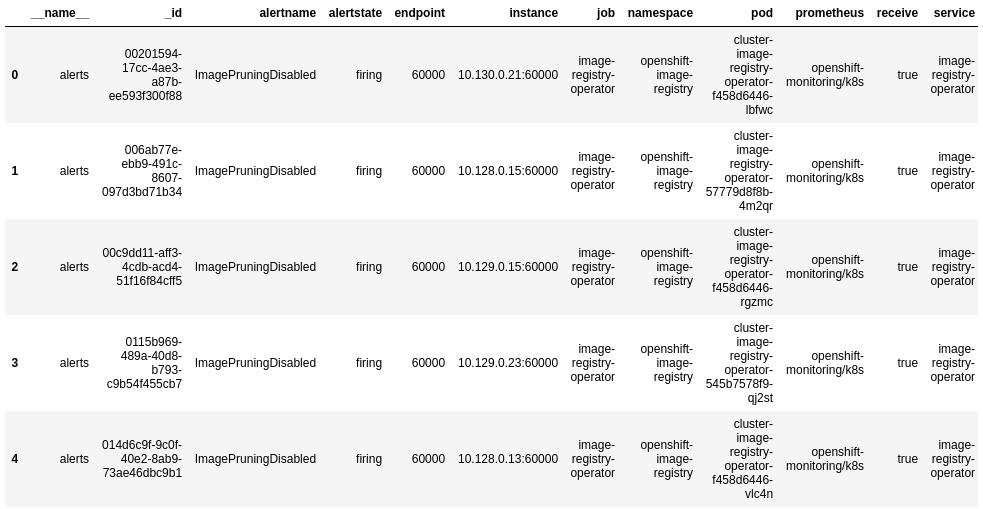

In [49]:
Image('publicdata.png')

The dataset contains different features and different alert names. In this method, we select a single alert and predict whether it wil fire or not within the next hour. We predict solely on the basis of information given for that alert, from the past 8 hours. In this case it would be a time series with binary 0/1 signifying whether or not an alert was fired at that time.

Before we begin modelling, we first try to filter out the dataset with respect to our chosen alert, and to layout the dataset which will give us an information about the state of alert for particular deployment id and corresponding timestamp. Since alertname is a categorical variable, we will first assign dummy variables to each alertname, and form a dataframe with respect to these dummy variables.

The dataframe cannot be fed directly to the classification model. We need to first follow certain steps like, 
- If there are any missing timestamps in the raw data frame. We need to find them and feed them in the dataframe.
- We need to assign a dummy variable to each alertname.
- We need to filter out duplicate entries from the raw data frame.

We first make a  choice of alert. For this case we choose alert: $'ImagePruningDisabled'$.

In [50]:
alert = 'ImagePruningDisabled'
timestamps = df.timestamp.unique()
total_timestamp = np.arange(timestamps[0], timestamps[len(timestamps)-1], 300)
missing_timestamp = np.array([i for i in total_timestamp if i not in timestamps])

Creating a dummy variable for each alert

In [51]:
alert_dummies = pd.get_dummies(df.alertname)
new_df = pd.concat([df, alert_dummies], axis=1)

Filtering out the dataframe for particular alert

In [52]:
df1 = new_df[['_id','timestamp',alert]]
df1 = df1.drop_duplicates()
def myfunc(g):
    return g.loc[:,alert].max()
result_df = df1.groupby(['_id','timestamp']).apply(myfunc)
result_df.head()
result_df = result_df.to_frame()
result_df = result_df.reset_index()
result_df.columns = ['_id','timestamp','alert']
alert_matrix = result_df.pivot(index = '_id', columns = 'timestamp', values = 'alert')
alert_matrix.fillna(0, inplace=True)
alert_matrix = pd.concat([alert_matrix, pd.DataFrame(columns=missing_timestamp)]) #adding missing timestamp
alert_matrix = alert_matrix.fillna(value=0)

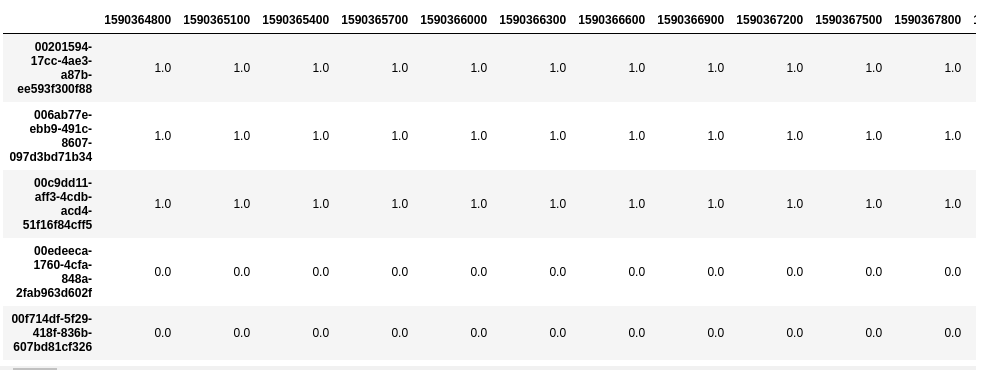

In [30]:
Image('public_datalayout.png')

**Some examples of alert state from past 8 hours and following 1 hour**

The bottom plots show different cases of alert state for different deployment ids. Each color represent each deployment id. On the left are plots corresponding to past 8 hours of data and on the right are plots corresponding to the next 1 hour of data. 

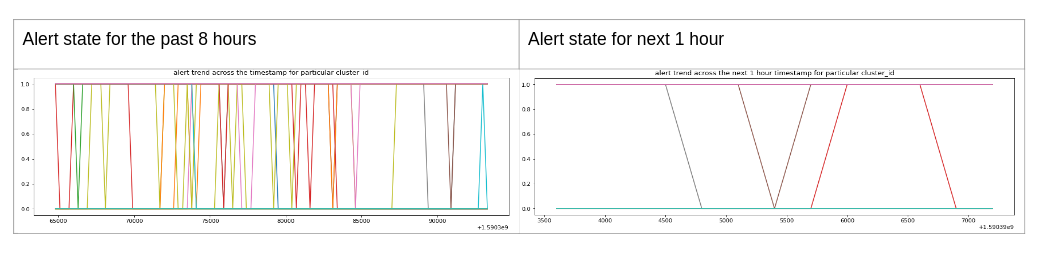

In [53]:
Image('alert_state_TS.png')

Now to train our models, we take the left side as an input for our models. We create an output array for model under the condition that if an alert has fired atleast once within the next 1 hour, it will be counted as 1/true else 0/False.

In [54]:
X = alert_matrix.iloc[:,:96] # input matrix is created considering the previus 6 hours data
Y1 = alert_matrix.iloc[:,96:109] #taking 1 hour of data
Y = Y1.apply(lambda x : x.any(), axis=1) #return 1 if 1 or else 0 for each t
Y = Y.to_frame()
Y = Y.astype(int)
Y.columns = ['alerts']

We use Random Forest and Support Vector classifier for predicting our alert state within the next hour.

**RANDOM FOREST CLASSIFICATION MODEL**

Random forest is the machine learning ensemble method that is widely used because of its flexibility, simplicity and often quality results. It is an ensembler classifier that consists of many decision trees generated from bootstrap instances. It outputs the class that is the mode of the output by individual trees.

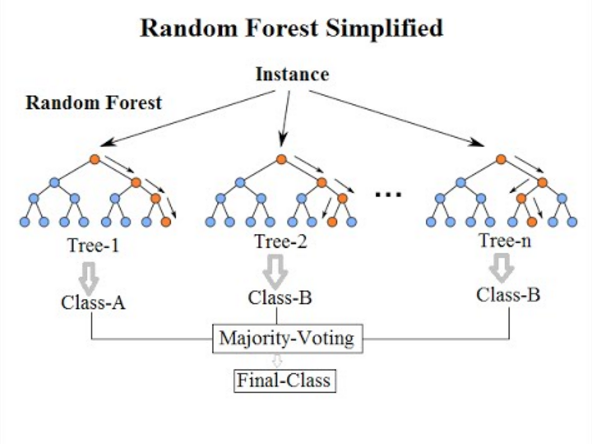

In [55]:
Image('randomforest.png')

**SUPPORT VECTOR MACHINE**

In machine learning, support vector machines are supervised machine learning models with associated learning algorithms that analyze data used for classification and regression analysis. As a classification algorithm, the classifier is defined by separating hyperplanes. In other words, given labelled data (supervised learning), the algorithm outputs the optimal hyperplane and based on it classifies the output into classes.In our case, we use Support vector classifier with RBF kernel.

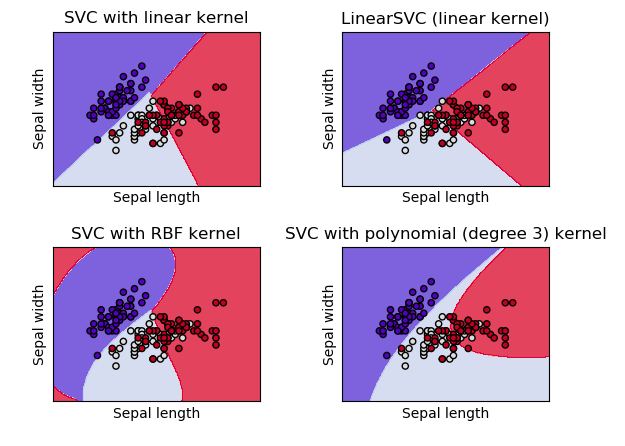

In [56]:
Image('svc.png')

**SPLITTING THE DATASET INTO TRAINING AND TEST SET**

In [57]:
X_Cols = X
Y_Cols = Y
X_train, X_test, Y_train, Y_test = train_test_split(X_Cols, Y_Cols, test_size = 0.2, random_state = 1, stratify = Y_Cols)

**BASELINE DETERMINATION**

To generate baseline prediciton, we use the mode of the alert state from the past 8 hours as the prediction for the next hour. Intuitively, this baseline represents the belief that if an alert has been firing for a long time then it will continue to fire in the next hour too, and if it hasn't been firing for a long time then it won't fire in the next hour as well.

In [58]:
Xmode = X_test.mode(axis=1)
Xmode = Xmode[[0]]

**BUILDING A MODEL AND PREDICTING**

In our case we have a classification problem because we have two discrete groups, alert fired(1) and alert not fired(0).

At first we split the models into training set and test set with the help of sklearn package tran_test_split. We choose RandomForestClassifier() and svm.SVC() classifier for random forest and support vector respectively.

We then train our models and test it and calculate the accuracy, precision and recall for the baseline estimation, random forest classifier and support vector classifier.

In [59]:
rand_frst_clf = RandomForestClassifier()
rand_frst_clf.fit(X_train, Y_train)
rf_pred = rand_frst_clf.predict(X_test)

In [60]:
svc_classifier = svm.SVC()
svc_classifier.fit(X_train, Y_train)
svc_pred = svc_classifier.predict(X_test)

**ACCURACY, PRECISION AND RECALL**

Accuracy is defined as the number of accurate predictions the model made on the test set. There are datasets where the accuracy of a model is a good measure. But in the case of some datasets where the ouput is outnumbered by one of the classes (i.e. an "imbalanced dataset"), accuracy is not a good measure. Instead, in those cases, we choose recall and precision to evaluate our model predictions.

Recall refers to the percentage of total relevant results correctly classified by an algorithm or in our case, recall refers to the percentage of relevant alerts actually predicted by the model. Precision is defined as the percentage of relevant alerts in relation to total alert state predicted. Unfortunately, naive maximizing one could come at the cost of the other. While recall expresses the ability to find all relevant instances in the dataset, precision expresses the proportion of data points that our model says was relevant which are actually relevant). 

As with most concepts in data science, there is a trade off in the metrics we choose to maximise. Forcing a model to improve only the recall can decrease its precision. Therefore, generally the f1-score (harmonic mean of precision and recall) is used to strike a balance between the two.

**F1 score**

The F1 score is the harmonic mean of precision and recall taking both metrics into account.
We use harmonic mean instead of simple averages because it punishes extreme values. If we want to create a balanced classification model with the optimal balance of recall and precision, then we try to maximize the F1 score.

**CONFUSION MATRIX**

A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in the dataset. Calculating a confusion matrix can give us a better idea of what our classification model is getting right and what type of errors it is making. 
Confusion matrix is useful in quickly calculating precision and recall given the predicted label of the model.

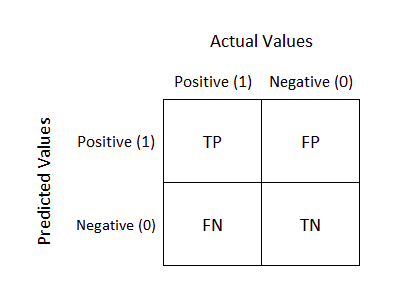

In [61]:
Image('CM.png')

**Accuracy**, **precision** and **recall** in terms of confusion matrix

**accuracy** = (true_negatives + true_positives)/(true_negatives + true_positives + false_negatives + false_positives)

**precision** = true_positives/(true_positives + false_positives)

**recall** = true_positives/(true_positives + false_negatives)

**BASELINE EVALUATION**

In [62]:
cf_matrix_baseline = confusion_matrix(Y_test,Xmode)

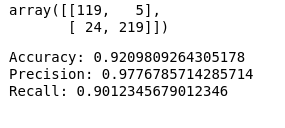

In [63]:
Image('baseline.png')

The confusion matrix shown above is from the baseline estimation. According to it, out of (219+24) i.e. 243 firing alert state. 219 was actually predicted true from the baseline, which makes the recall value of 90%.  

**MODEL EVALUATION**

In [64]:
cf_matrix_rf = confusion_matrix(Y_test , rf_pred)
cf_matrix_svc = confusion_matrix(Y_test, svc_pred)

[plot_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) is used to visually represent a confusion matrix as shown in the Confusion matrix example, which creates the following figure:

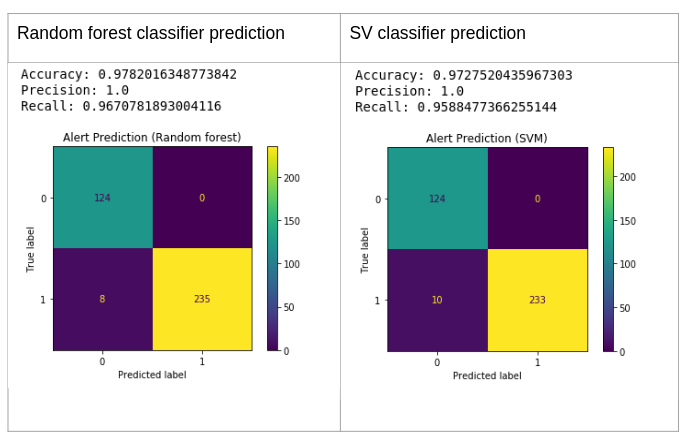

In [65]:
Image('rf_and_svc_pred.png')

The confusion matrix shown above are for random forest classifier and support vector classifier. Out of 243 total alert firing state 235 was actually predicted true from random forest classifier and 233 state was actually predicted true from support vector classifier. This leads to the recall value to be ~96% and ~95% which is greater than that of baseline estimation.

**CONCLUSION**

We tried to predict the alert firing within the next one hour based on its state from the previous 8 hours of data. We used random forest and SVM classification algorithm for forecasting. 

For the baseline determination we assumed that for a given input matrix, the output is dependent on the number of alerts fired or not in the previous 8 hours. If the alert state is 0 for the maximum number of time, then the output state will be 0 and vise versa. Hence, we calculated the mode of each row from the input matrix to generate the output.We then compared the recall value from the models as well as from the baseline assumption. The recall value from the baseline is ~ 90% whereas the recall value from the random forest model and SVM model are ~96% and ~95% which suggest that our model does have a good predicting power.

The analysis is giving us an interesting prespective of predicting an alert from the previous data, where we ignore the dependencies of alert with other alerts and with other features.

# Additional Resources


- [GitRepo](https://github.com/aicoe-aiops/ocp-alert-prediction-public)